# Read And Partition Data

In [ ]:
## download eigenpairs
!gdown --id 13EO_laLQDRejB0fXzT2XATVitAJqqXum
!gdown --id 1lmACsL2206vXcmCXR-VCkmBrfvNlklsr
## download data
!gdown --id "1zAHe0nRAxzTsrBm3pNfqjQZeHd-uKgTd"
!unzip -q "/content/altegrad-2020.zip"

Downloading...
From: https://drive.google.com/uc?id=13EO_laLQDRejB0fXzT2XATVitAJqqXum
To: /content/eigvecs.txt
584MB [00:09, 59.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lmACsL2206vXcmCXR-VCkmBrfvNlklsr
To: /content/eigvals.txt
100% 2.49k/2.49k [00:00<00:00, 5.68MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zAHe0nRAxzTsrBm3pNfqjQZeHd-uKgTd
To: /content/altegrad-2020.zip
19.8MB [00:00, 32.2MB/s]


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import logging
logger = logging.getLogger('my_logger')

logger.setLevel(logging.DEBUG)

# read training data
df_train = pd.read_csv('train.csv', dtype={'authorID': np.int64, 'h_index': np.float32})
df_train_val = pd.read_csv('train.csv', dtype={'authorID': np.int64, 'h_index': np.float32})
df_train, df_val = train_test_split(df_train_val, test_size=0.2)

#####
df_train = pd.read_csv('train.csv', dtype={'authorID': np.int64, 'h_index': np.float32})## delete afterwards.
df_train["is_train"]=True

n_train = df_train.shape[0]
n_val = df_val.shape[0]

# read test data
df_test = pd.read_csv('test.csv', dtype={'authorID': np.int64})
df_test["is_train"]=False
n_test = df_test.shape[0]
# full data 
df_full = pd.concat((df_train,df_test),axis=0)
n_full = df_full.shape[0]
# load the graph    
G_nx = nx.read_edgelist('collaboration_network.edgelist', delimiter=' ', nodetype=int)
n_nodes = G_nx.number_of_nodes()
n_edges = G_nx.number_of_edges() 
print('Number of nodes:', n_nodes)
print('Number of edges:', n_edges)

Number of nodes: 231239
Number of edges: 1777338


In [ ]:
import torch
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#######


train_nodes = df_train["authorID"].values
test_nodes = df_test["authorID"].values
#########
train_labels = df_train["h_index"].values
###############
nodes = list(G_nx.nodes())
nodes_to_idx = {node:idx for idx,node in enumerate(nodes)}
idx_to_nodes = {idx:node for idx,node in enumerate(nodes)}
###############
df_full['author_node_number']= [nodes_to_idx[author] for author in df_full["authorID"]]
###############
train_idxs = torch.LongTensor([nodes_to_idx.get(key) for key in train_nodes]).to(device)
test_idxs = torch.LongTensor([nodes_to_idx.get(key) for key in test_nodes]).to(device)

In [ ]:
df_full = df_full.sort_values(by=['author_node_number'])
df_full.head()

,authorID,h_index,is_train,h_index_pred,author_node_number
44411,2002218453,NaN,False,NaN,0
22402,1999212242,2.0,True,NaN,1
53063,2032640503,NaN,False,NaN,2
173555,2475931411,NaN,False,NaN,3
173812,2477743428,NaN,False,NaN,4


# Spectral clustering on GPU :


In [ ]:
from networkx.linalg.graphmatrix import adjacency_matrix
import scipy as sp


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def rw_laplacian(G):
    nodelist = list(G.nodes())
    A = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, format="csr")
    ### Add self edges to avoid 0 in the diagonal
    ### This does not affect the laplacian
    n, m = A.shape
    A += sp.sparse.eye(n)
    ##############
    diags = A.sum(axis=1)
    D = sp.sparse.spdiags(diags.flatten(), [0], m, n, format="csr")
    D_inv = D.power(-1)

    return sp.sparse.eye(n) - D_inv @ A

G_mini = G_nx.subgraph(train_nodes)
L_mini = rw_laplacian(G_mini)
L_full = rw_laplacian(G_nx)

In [ ]:
def select_eigvals(eigvals):
    """ Automatic strategy for finding the best number of cluster
    This looks for the highest slope in the eigenvalues """

    ### relative difference (lamda_i+1-lamda_i)/lamda_i
    ### get index of first non zero element
    nz = (eigvals!=0).argmax()  
    diff  = (eigvals[nz+1:]-eigvals[nz:-1])/eigvals[nz:-1]
    k = np.argmax(diff)
    logger.debug(f'First non zero entry is {nz} Maximum eigen gap is {k} ')
    return np.array(range(1,nz+k+2)) 

def get_eigens(L,n_eigenpairs=10):
    
    
    L_torch = sparse_to_torch_sparse(L).to(device)
    eigvals,eigvecs = torch.lobpcg(L_torch,k=n_eigenpairs,n=n_eigenpairs*5,largest=False,method="ortho")
    logger.debug("Done computing eigen pairs")
    
  
    eigvals = eigvals.cpu().detach().numpy()
    eigvecs = eigvecs.cpu().detach().numpy()
    
    eigvecs = eigvecs.real
    logger.debug("eigvecs shape"+str(eigvecs.shape))

    ### sort eigenvalues
    ### sort eigvenvectors by eigenvalues
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx].real
    eigvecs = eigvecs[:,idx].real 

    ## ignore first eigenvector since our graph is connected
    return eigvals[1:],eigvecs[:,1:]

In [ ]:
# from google.colab import files


# eigvals,eigvecs = get_eigens(L_full,n_eigenpairs=100)
# plt.plot(eigvals)

# np.savetxt('eigvals.txt', eigvals)
# np.savetxt('eigvecs.txt', eigvecs)

# files.download('eigvecs.txt') 
# files.download('eigvals.txt') 

In [ ]:
def torch_kmeans(x, K=10, Niter=100):
    """Implements Lloyd's algorithm for the Euclidean metric."""

    
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = x[:K].clone()  # Simplistic initialization for the centroids

    x_i = torch.FloatTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = torch.FloatTensor(c.view(1, K, D))  # (1, K, D) centroids
    
    ## Pass everything to device
    x,x_i,c_j,c = x.to(device),x_i.to(device),c_j.to(device),c.to(device)

    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        D_ij = ((x_i - c_j) ** 2) # (N,K,D)
        logger.debug(f'Before sum Dij size{D_ij.size()}')
        D_ij= D_ij.sum(dim=-1)  # (N, K) symbolic squared distances
  
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster
        

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_()
        logger.debug(f'cl[:, None].repeat(1, D){cl[:, None].repeat(1, D).size()}')
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Divide by the number of points per cluster:
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        c /= Ncl  # in-place division to compute the average

        logger.debug(f'C size{c.size()} cl size{cl.size()}')

    return cl, c

In [ ]:
from sklearn.cluster import KMeans as kmeans


def spectral_clustering(eigvecs,n_clusters,use_gpu=True):

    if not n_clusters:

        chosen_eig_indices =select_eigvals(eigvals)
        n_clusters = chosen_eig_indices.shape[0]+1
  
    else :
      chosen_eig_indices= np.arange(0,n_clusters-1)
        
    
    if use_gpu : 
    
      X = torch.FloatTensor(eigvecs[:,chosen_eig_indices])
      logger.debug(f'Chosen eigenvec shape {X.size()}')
      Y, cluster_centers = torch_kmeans(X ,n_clusters)
      return Y.cpu().detach().numpy()

    else :

      km = kmeans(n_clusters=n_clusters)
      Y = km.fit_predict(eigvecs[:,chosen_eig_indices])
      return Y  

# Compute cluster statistics:

In [ ]:
eigvecs = np.loadtxt("eigvecs.txt")
eigvals = np.loadtxt("eigvals.txt")

In [ ]:
from networkx.algorithms.community.quality import modularity


def clustering_to_sets(clustering):

    """Group each cluster into a set

    This is the required format for modularity fct"""

    clustering = clustering.flatten()
    communities = []

    for cluster in np.unique(clustering):
      node_idxs  = np.where(clustering==cluster)[0]
      author_idxs = [idx_to_nodes[idx] for idx in node_idxs]
      communities.append(set(author_idxs))

    return communities
    

def compute_clustering_stats(clustering):

  communities = clustering_to_sets(clustering)
  c_modularity = modularity(G_nx,communities)
  print(f'Clustering modularity{c_modularity}')
  cluster_means=[]
  cluster_vars=[]
  cluster_meds= []

  cluster_stats = {"means":[],"vars":[],"meds":[]}

  for cluster in np.unique(clustering):
    #select from the cluster the nodes that fall in the training set:
    
    cluster_size = df_full[(df_full['node_cluster']==cluster)].shape[0]

    train_cluster = df_full[(df_full['is_train']==True) & (df_full['node_cluster']==cluster)] 
    n_train_nodes  =train_cluster.shape[0]
    train_coverage = np.round(n_train_nodes/cluster_size*100)
    ############################################
    cluster_targets = train_cluster['h_index'].values
    cluster_mean = np.mean(cluster_targets)
    cluster_var = np.std(cluster_targets)
    cluster_median = np.median(cluster_targets)
    print(f'Cluster#{cluster}: n_total_nondes {cluster_size} / train % {train_coverage} mean {cluster_mean}, var {cluster_var}, median {cluster_median}')

    cluster_stats["means"].append(cluster_mean)
    cluster_stats["vars"].append(cluster_var)
    cluster_stats["meds"].append(cluster_median)
  
  return c_modularity, cluster_stats



Clustering modularity0.0
Cluster#0: n_total_nondes 231239 / train % 10.0 mean 9.58804702758789, var 12.3764009475708, median 5.0
_______________________________________________
Clustering modularity0.38753670008753244
Cluster#0: n_total_nondes 77706 / train % 10.0 mean 9.248538970947266, var 12.059208869934082, median 5.0
Cluster#1: n_total_nondes 4655 / train % 10.0 mean 8.0, var 10.464853286743164, median 5.0
Cluster#2: n_total_nondes 136888 / train % 10.0 mean 9.91586971282959, var 12.605766296386719, median 5.0
Cluster#3: n_total_nondes 3484 / train % 10.0 mean 8.931507110595703, var 13.086360931396484, median 5.0
Cluster#4: n_total_nondes 6216 / train % 11.0 mean 9.03675365447998, var 12.666115760803223, median 4.0
Cluster#5: n_total_nondes 2290 / train % 11.0 mean 7.315573692321777, var 9.491302490234375, median 4.0
_______________________________________________
Clustering modularity0.0301782403984579
Cluster#0: n_total_nondes 991 / train % 12.0 mean 6.599999904632568, var 8.489

Text(0, 0.5, 'Modularity')

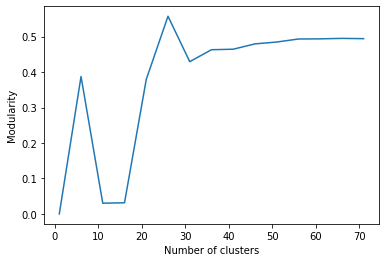

In [ ]:
logger.setLevel(logging.WARNING)
mods=[]
for i in range(1,75,5):

  clustering = spectral_clustering(eigvecs, n_clusters=i,use_gpu=True)
  df_full["node_cluster"]=clustering
  mod,_= compute_clustering_stats(clustering)
  mods.append(mod)
  print("_______________________________________________")

plt.plot(list(range(1,75,5)),mods)
plt.xlabel("Number of clusters")
plt.ylabel("Modularity")

Clustering modularity0.4971533653759542
Cluster#0: n_total_nondes 114 / train % 7.0 mean 10.625, var 12.154603004455566, median 4.0
Cluster#1: n_total_nondes 41 / train % 10.0 mean 6.25, var 3.766629695892334, median 5.5
Cluster#2: n_total_nondes 213 / train % 13.0 mean 6.9259257316589355, var 5.906217098236084, median 5.0
Cluster#3: n_total_nondes 50 / train % 16.0 mean 16.0, var 29.832868576049805, median 2.5
Cluster#4: n_total_nondes 60 / train % 12.0 mean 21.714284896850586, var 41.11209487915039, median 3.0
Cluster#5: n_total_nondes 70 / train % 11.0 mean 5.375, var 3.8058342933654785, median 5.0
Cluster#6: n_total_nondes 77 / train % 10.0 mean 13.875, var 15.631998062133789, median 7.0
Cluster#7: n_total_nondes 99 / train % 9.0 mean 6.888888835906982, var 5.877346992492676, median 4.0
Cluster#8: n_total_nondes 57 / train % 5.0 mean 1.0, var 0.0, median 1.0
Cluster#9: n_total_nondes 644 / train % 9.0 mean 7.440678119659424, var 9.113728523254395, median 5.0
Cluster#10: n_total_non

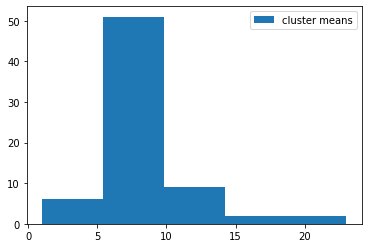

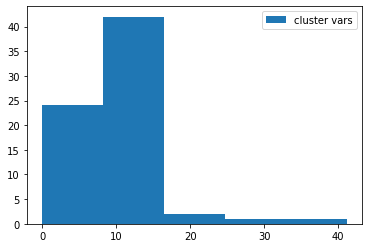

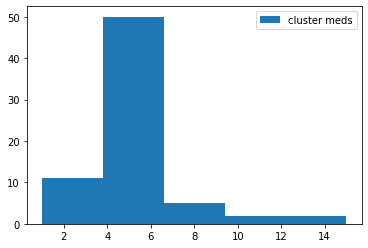

In [ ]:
clustering = spectral_clustering(eigvecs, n_clusters=70,use_gpu=True)
df_full["node_cluster"]=clustering
mod,stats = compute_clustering_stats(clustering)


for metric_name,metric_values in stats.items() :
  plt.hist(metric_values,bins=5,label='cluster '+str(metric_name))
  plt.legend()
  plt.show()

In [ ]:
logger.setLevel(logging.WARNING)

# compute node clusters
clustering = spectral_clustering(eigvecs, n_clusters=75,use_gpu=True)
### compute cluster wise statistics
### dataframe is order by the idx of the node in THE GRAPH
df_full["node_cluster"]=clustering
cluster_mean = df_full[df_full['is_train']==True].groupby('node_cluster')['h_index'].mean().values
cluster_var = df_full[df_full['is_train']==True].groupby('node_cluster')['h_index'].std().values
#cluster_median = df_full[df_full['is_train']==True].groupby('node_cluster')['h_index'].median().values
### compute 10% quantiles
cluster_quantiles = [df_full[df_full['is_train']==True].groupby('node_cluster')['h_index'].quantile(0.1*q).values for q in range(11)]

In [ ]:
### Node cluster attributes

df_full['c_mean'] = df_full.apply(lambda row: cluster_mean[row['node_cluster']], axis=1)
df_full['c_var'] = df_full.apply(lambda row: cluster_var[row['node_cluster']], axis=1)

for i in range(11):
  df_full['c_quantile_'+str(i*10)+'%'] = df_full.apply(lambda row: cluster_quantiles[i][row['node_cluster']], axis=1)

### Individual node attributes 
core_number = nx.core_number(G_nx)
avg_neighbor_degree = nx.average_neighbor_degree(G_nx)
degree = G_nx.degree()


df_full['degree'] = df_full.apply(lambda row: degree[row['authorID']], axis=1)
df_full['core_n'] = df_full.apply(lambda row: core_number[row['authorID']], axis=1)
df_full['avg_nghbr_degree'] = df_full.apply(lambda row: avg_neighbor_degree[row['authorID']], axis=1)


In [ ]:
df_full.head()

,authorID,h_index,is_train,h_index_pred,author_node_number,node_cluster,c_mean,c_var,c_quantile_0%,c_quantile_10%,c_quantile_20%,c_quantile_30%,c_quantile_40%,c_quantile_50%,c_quantile_60%,c_quantile_70%,c_quantile_80%,c_quantile_90%,c_quantile_100%,degree,core_n,avg_nghbr_degree
44411,2002218453,NaN,False,NaN,0,0,10.625000,12.993817,2.0,2.7,3.4,4.0,4.0,4.0,5.2,9.4,14.8,24.6,40.0,19,11,12.368421
22402,1999212242,2.0,True,NaN,1,1,7.000000,5.000000,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,8,8,10.250000
53063,2032640503,NaN,False,NaN,2,2,6.826087,6.393549,1.0,2.0,2.0,3.0,3.0,4.0,6.0,7.4,10.8,16.0,24.0,12,8,8.416667
173555,2475931411,NaN,False,NaN,3,3,16.000000,31.892677,1.0,1.0,1.4,2.0,2.0,2.5,4.8,11.1,12.6,37.3,94.0,8,8,10.250000
173812,2477743428,NaN,False,NaN,4,4,26.714285,44.481136,1.0,1.6,2.2,2.8,3.0,3.0,9.6,19.6,36.4,74.0,122.0,8,8,10.250000


In [ ]:
#### save data to drive

df_save = pd.get_dummies(df_full,prefix=['node_cluster'], columns = ['node_cluster'], drop_first=True)
#df_save = df_full.drop(columns=)
#df_full.to_csv("node_cluster_data.csv",index=False)
df_save = df_save.drop(columns=['h_index','is_train','h_index_pred'])
df_save.to_csv("node_cluster_data.csv",index=False)

from google.colab import drive
drive.mount('/gdrive')
!cp '/content/node_cluster_data.csv' '/gdrive/My Drive/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
df_save.head()

,authorID,author_node_number,c_mean,c_var,c_quantile_0%,c_quantile_10%,c_quantile_20%,c_quantile_30%,c_quantile_40%,c_quantile_50%,c_quantile_60%,c_quantile_70%,c_quantile_80%,c_quantile_90%,c_quantile_100%,degree,core_n,avg_nghbr_degree,node_cluster_1,node_cluster_2,node_cluster_3,node_cluster_4,node_cluster_5,node_cluster_6,node_cluster_7,node_cluster_8,node_cluster_9,node_cluster_10,node_cluster_11,node_cluster_12,node_cluster_13,node_cluster_14,node_cluster_15,node_cluster_16,node_cluster_17,node_cluster_18,node_cluster_19,node_cluster_20,node_cluster_21,node_cluster_22,...,node_cluster_35,node_cluster_36,node_cluster_37,node_cluster_38,node_cluster_39,node_cluster_40,node_cluster_41,node_cluster_42,node_cluster_43,node_cluster_44,node_cluster_45,node_cluster_46,node_cluster_47,node_cluster_48,node_cluster_49,node_cluster_50,node_cluster_51,node_cluster_52,node_cluster_53,node_cluster_54,node_cluster_55,node_cluster_56,node_cluster_57,node_cluster_58,node_cluster_59,node_cluster_60,node_cluster_61,node_cluster_62,node_cluster_63,node_cluster_64,node_cluster_65,node_cluster_66,node_cluster_67,node_cluster_68,node_cluster_69,node_cluster_70,node_cluster_71,node_cluster_72,node_cluster_73,node_cluster_74
44411,2002218453,0,10.625000,12.993817,2.0,2.7,3.4,4.0,4.0,4.0,5.2,9.4,14.8,24.6,40.0,19,11,12.368421,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22402,1999212242,1,7.000000,5.000000,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,8,8,10.250000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53063,2032640503,2,6.826087,6.393549,1.0,2.0,2.0,3.0,3.0,4.0,6.0,7.4,10.8,16.0,24.0,12,8,8.416667,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
173555,2475931411,3,16.000000,31.892677,1.0,1.0,1.4,2.0,2.0,2.5,4.8,11.1,12.6,37.3,94.0,8,8,10.250000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
173812,2477743428,4,26.714285,44.481136,1.0,1.6,2.2,2.8,3.0,3.0,9.6,19.6,36.4,74.0,122.0,8,8,10.250000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
!cp '/content/node_cluster_data.csv' '/gdrive/My Drive/'

In [ ]:
X_train=df_full[df_full['is_train']==True]
y_train = X_train['h_index']
X_train = X_train.drop(['authorID', 'node_cluster','is_train','h_index_pred','author_node_number','h_index'], axis=1)
#X_train = X_train.drop(['authorID', 'node_cluster','is_train','h_index_pred','author_node_number','h_index','degree','core_n','avg_nghbr_degree'], axis=1)

In [ ]:
X_train[X_train.isna().any(axis=1)]

,c_mean,c_var,c_quantile_0%,c_quantile_10%,c_quantile_20%,c_quantile_30%,c_quantile_40%,c_quantile_50%,c_quantile_60%,c_quantile_70%,c_quantile_80%,c_quantile_90%,c_quantile_100%,degree,core_n,avg_nghbr_degree
